In [36]:
from datasets import Dataset, DatasetDict
from tqdm import tqdm
import pandas as pd
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt

import wandb
api = wandb.Api()

In [46]:
project_name = "kyledevinobrien1/AK_Tests"
runs = api.runs(project_name)
all_runs_frame = None
for run in tqdm(runs):
    if run.state != "finished":
        continue

    try:
        config_frame = pd.read_json(json.dumps(run.config), orient="index").T
        summary_frame = pd.read_json(json.dumps(run.summary_metrics), orient="index").T
        combined_frame = pd.concat([config_frame, summary_frame], axis=1)
        if all_runs_frame is None:
            all_runs_frame = combined_frame
        else:
            all_runs_frame = pd.concat([all_runs_frame, combined_frame])
    except:
        print(f"Failed to load run {run.id}")
        continue

all_runs_frame


  0%|          | 0/27 [00:00<?, ?it/s]/tmp/ipykernel_459437/2171342941.py:9: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  config_frame = pd.read_json(json.dumps(run.config), orient="index").T
/tmp/ipykernel_459437/2171342941.py:10: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  summary_frame = pd.read_json(json.dumps(run.summary_metrics), orient="index").T
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
ERROR:tornado.general:SEND Error: Host unreachable
 15%|█▍        | 4/27 [00:51<04:55

Failed to load run lnlu5xmz


,lr,tag,edit,rank,save,seed,dtype,wandb,device,method,...,nsamples,percdamp,act_order,groupsize,zero_point,use_variant,prune_method,sparsity_type,static_groups,true_sequential
0,0.005,lora-rightarrow-rmu,lora,8,out/,42,torch.float,online,0,none,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0.00005,ft-rightarrow-rmu,ft,NaN,out/,42,torch.bfloat16,online,0,none,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0.00005,rmu-rightarrow-ft,ft,NaN,out/,42,torch.bfloat16,online,0,none,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,sparsegpt0.65\%-rightarrow-rmu,none,NaN,out/,0,torch.bfloat16,online,0,prune,...,128,0.01,False,128,True,False,sparsegpt,unstructured,False,False
0,NaN,wanda0.45\%-rightarrow-rmu,none,NaN,out/,0,torch.bfloat16,online,0,prune,...,128,0.01,False,128,True,False,wanda,unstructured,False,False
0,NaN,sparsegpt0.45\%-rightarrow-rmu,none,NaN,out/,0,torch.bfloat16,online,0,prune,...,128,0.01,False,128,True,False,sparsegpt,unstructured,False,False
0,NaN,sparsegpt0.25\%-rightarrow-rmu,none,NaN,out/,0,torch.bfloat16,online,0,prune,...,128,0.01,False,128,True,False,sparsegpt,unstructured,False,False
0,NaN,wanda0.65\%-rightarrow-rmu,none,NaN,out/,0,torch.bfloat16,online,0,prune,...,128,0.01,False,128,True,False,wanda,unstructured,False,False
0,NaN,rmu-rightarrow-sparsegpt0.65\%,none,NaN,out/,0,torch.bfloat16,online,0,prune,...,128,0.01,False,128,True,False,sparsegpt,unstructured,False,False
0,NaN,rmu-rightarrow-sparsegpt0.45\%,none,NaN,out/,0,torch.bfloat16,online,0,prune,...,128,0.01,False,128,True,False,sparsegpt,unstructured,False,False


In [42]:
# ["lr", "tag", "edit", "rank", "save", "seed", "dtype", "wandb", "device", "method", "rmu_lr", "dataset", "unlearn", "alg_name", "compress", "edit_set", "rmu_seed", "ckpt_path", "kl_factor", "load_ckpt", "lora_type", "num_steps", "rmu_alpha", "save_ckpt", "stats_dir", "batch_size", "lora_alpha", "max_length", "model_name", "save_model", "compression", "rmu_max_len", "rmu_min_len", "edit_dataset", "lora_dropout", "rmu_layer_id", "weight_decay", "interventions", "rmu_layer_ids", "rmu_param_ids", "eval_zero_shot", "model_parallel", "rmu_batch_size", "sparsity_ratio", "target_modules", "unlearn_method", "norm_constraint", "number_of_edits", "rmu_forget_corpora", "rmu_retain_corpora", "compression_dataset", "rmu_max_num_batches", "rmu_steering_coeffs", "PPL edits", "wmdp_cyber", "wmdp_bio accuracy", "mmlu stderr", "Local recall", "wmdp_cyber accuracy", "Success recall", "FLOPs", "Locality", "wmdp_bio", "mmlu accuracy", "PPl edits unmasked", "Generalization recall", "Metrics", "_step", "Average bits", "mmlu", "_wandb", "_runtime", "Rewrite accuracy", "PPL", "Latency", "PPl QA", "Generalization", "wmdp_bio stderr", "wmdp_cyber stderr", "_timestamp", "ln_f_module", "lm_head_module", "mlp_module_tmp", "attn_module_tmp", "layer_module_tmp", "rewrite_module_tmp", "objective_optimization", "sym", "wbits", "nearest", "new_eval", "nsamples", "percdamp", "act_order", "groupsize", "zero_point", "use_variant", "prune_method", "sparsity_type", "static_groups", "true_sequential"]

/tmp/ipykernel_459437/2978898783.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wanda_then_rmu_frame["plot_tag"] = "Wanda->RMU"


,lr,tag,edit,rank,save,seed,dtype,wandb,device,method,...,percdamp,act_order,groupsize,zero_point,use_variant,prune_method,sparsity_type,static_groups,true_sequential,plot_tag
0,NaN,wanda0.45\%-rightarrow-rmu,none,NaN,out/,0,torch.bfloat16,online,0,prune,...,0.01,False,128,True,False,wanda,unstructured,False,False,Wanda->RMU
0,NaN,wanda0.65\%-rightarrow-rmu,none,NaN,out/,0,torch.bfloat16,online,0,prune,...,0.01,False,128,True,False,wanda,unstructured,False,False,Wanda->RMU


/tmp/ipykernel_459437/2978898783.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rmu_then_wanda_frame["plot_tag"] = "RMU->Wanda"


,lr,tag,edit,rank,save,seed,dtype,wandb,device,method,...,percdamp,act_order,groupsize,zero_point,use_variant,prune_method,sparsity_type,static_groups,true_sequential,plot_tag
0,NaN,rmu-rightarrow-wanda0.45\%,none,NaN,out/,0,torch.bfloat16,online,0,prune,...,0.01,False,128,True,False,wanda,unstructured,False,False,RMU->Wanda
0,NaN,rmu-rightarrow-wanda0.65\%,none,NaN,out/,0,torch.bfloat16,online,0,prune,...,0.01,False,128,True,False,wanda,unstructured,False,False,RMU->Wanda
0,NaN,rmu-rightarrow-wanda0.25\%,none,NaN,out/,0,torch.bfloat16,online,0,prune,...,0.01,False,128,True,False,wanda,unstructured,False,False,RMU->Wanda


<Axes: xlabel='sparsity_ratio', ylabel='mmlu accuracy'>

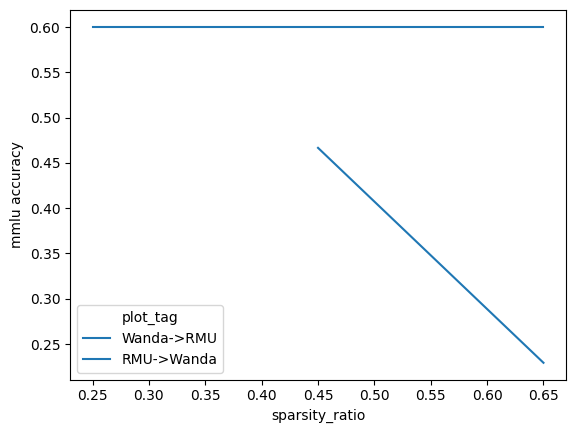

In [45]:
wanda_then_rmu_frame = all_runs_frame[(all_runs_frame["tag"].str.contains("wanda")) & all_runs_frame["tag"].str.contains("-rmu")]
wanda_then_rmu_frame["plot_tag"] = "Wanda->RMU"
display(wanda_then_rmu_frame)

rmu_then_wanda_frame = all_runs_frame[(all_runs_frame["tag"].str.contains("wanda")) & all_runs_frame["tag"].str.contains("rmu-")]
rmu_then_wanda_frame["plot_tag"] = "RMU->Wanda"
display(rmu_then_wanda_frame)

# create a line plot of the two where the x axis is sparsity and the y axis is accuracy
fig, ax = plt.subplots()
sns.lineplot(data=wanda_then_rmu_frame, x="sparsity_ratio", y="mmlu accuracy", hue="plot_tag", ax=ax)
sns.lineplot(data=rmu_then_wanda_frame, x="sparsity_ratio", y="mmlu accuracy", hue="plot_tag", ax=ax)

